# M2M PLIMS Data Access Testing

#### Intro
Starting with the first deployment of the Coastal Pioneer Mid-Atlantic Bight (MAB) Array, OOI collected data from a plankton imaging instrument (McLane Research Labs Imaging Flow Cytobot) deployed at 7 meters depth on the near-surface instrument frame. The introduction of a new instrument to the physical OOI infrastructure required new parsing code and metadata to ingest the data into the OOI Cyberinfrastructure. Once ingested, the data will be available for machine-to-machine (M2M) download from OOI's THREDDS server and then pushed to Data Explorer on a near-real-time basis.

#### Purpose
Telemetered data from the first PLIMS deployment on Central Surface Mooring has been ingested into the Dev0 development platform where the relevant parsers are being tested. After the parameters and relevant metadata were decided upon, test NetCDFs were created for review to confirm that the parsers could create a valid and accurate dataset. This data pathway from ingested data to datasets asynchronously compiled on demand now must be tested from the perspective of a data user.

#### Objectives:

* Test Output: Request HDR science and engineering datasets with different request parameters.
* Dataset Review: Look for incorrect data values, types or metadata to provide feedback to CI. 

#### Supporting tools
If you want to run this notebook as-is, you will need to clone A. Reed's [ooinet repo](https://github.com/reedan88/OOINet) to your local machine and install it as a local dev repo (which adds it to your base path). You'll also need the [ooi_data_explorations repo](https://github.com/oceanobservatories/ooi-data-explorations). Lastly, you'll want to install the ```ioos_qc``` [python package](https://github.com/ioos/ioos_qc). 


In [1]:
# Import libraries
import os
import re
import gc
import io
import ast
import netrc
import pandas as pd
import numpy as np
import xarray as xr
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import glob

# Import dask
import dask
from dask.diagnostics import ProgressBar

# Import pyplot and show plots inline
import matplotlib.pyplot as plt
%matplotlib inline 

Import the M2M tool

In [2]:
from ooinet import M2M
from ooinet.Instrument.common import process_file

Import the relevant ooi_data_explorations tools

In [3]:
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.common import get_vocabulary

---
## Request and load the data
Sub in ooinet-dev0-west.intra.oceanobservatories.org into the avaialbe API urls


In [4]:
for key in M2M.URLS:
    url = M2M.URLS.get(key)
    if "opendap" in url:
        M2M.URLS[key] = re.sub("opendap", "opendap-dev0-west.intra", url)
    else:
        M2M.URLS[key] = re.sub("ooinet","ooinet-dev0-west.intra", url)

Sub in dev0 OOINet credentials from netrc file

In [5]:
try:
    nrc = netrc.netrc()
    M2M.AUTH = nrc.authenticators('ooinet-dev0-west.intra.oceanobservatories.org')
    M2M.login, M2M.password = M2M.AUTH[0], M2M.AUTH[2]
    if M2M.AUTH is None:
        raise RuntimeError(
            'No entry found for machine ``ooinet-dev0-west.intra.oceanobservatories.org`` in the .netrc file')
except FileNotFoundError as e:
    raise OSError(e, os.strerror(e.errno), os.path.expanduser('~'))

Search the Dev1 server for available datasets

In [6]:
M2M.URLS

{'data': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12576/sensor/inv',
 'anno': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12580/anno/find',
 'vocab': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12586/vocab/inv',
 'asset': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587',
 'deploy': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587/events/deployment/inv',
 'preload': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12575/parameter',
 'cal': 'https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12587/asset/cal',
 'fileServer': 'https://opendap-dev0-west.intra.oceanobservatories.org/thredds/fileServer/',
 'dodsC': 'https://opendap-dev0-west.intra.oceanobservatories.org/thredds/dodsC/',
 'goldCopy': 'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/',
 'goldCopy_fileServer': 'https://thredds.dataexplorer.oceanobservatories.org/thre

In [7]:
ds_df = M2M.search_datasets(array="CP10CNSM")
ds_df.reset_index(inplace=True)
# ds_df

Searching https://ooinet-dev0-west.intra.oceanobservatories.org/api/m2m/12576/sensor/inv/CP10CNSM


Find the available datastreams for a given **refdes**

In [8]:
# url = ds_df["url"][0]
# url = "/".join((url, 'telemetered', 'plims_a_hdr_instrument'))
# # Query the preload data
# preload_data = M2M.get_api(url)
# preload_data

In [9]:
datastreams = M2M.get_datastreams("CP10CNSM-RID27-07-PLIMSA000")
datastreams

,refdes,method,stream
0,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_adc_instrument
1,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_hdr_engineering
2,CP10CNSM-RID27-07-PLIMSA000,recovered_host,plims_a_hdr_instrument
3,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_adc_instrument
4,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_engineering
5,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_instrument


In [10]:
# Define a generic preprocessing routine. Do NOT use any of the ooi_data_explorations "process_instrument" methods. We want to be comparing "apples-to-apples" 
def preprocess(ds):
    ds = process_file(ds)
    return ds

In [11]:
# # Define function to change primary dimension to the sample start timestamp
# def swap_timestamps(ds):
#     """
#     Swaps the timestamps from the host to the instrument timestamp
#     for the CTDBPs
#     """
#     if "internal_timestamp" in ds.variables:
#         # Calculate the timestamp
#         inst_time = ds.internal_timestamp.to_pandas()
#         attrs = ds.internal_timestamp.attrs
#         # Convert the time
#         inst_time = inst_time.apply(lambda x: np.datetime64(int(x), 's'))
#         # Create a DataArary
#         da = xr.DataArray(inst_time, attrs=attrs)
#         ds['internal_timestamp'] = da
#     ds = ds.set_coords(["internal_timestamp"])
#     ds = ds.swap_dims({"time":"internal_timestamp"})
#     ds = ds.reset_coords("time")
#     ds = ds.rename_vars({"time":"host_time"})
#     ds["host_time"].attrs = {
#         "long_name": "DCL Timestamp",
#         "comment": ("The timestamp that the instrument data as recorded by the mooring data "
#                     "concentration logger (DCL)")
#     }
#     ds = ds.rename({"internal_timestamp":"time"})
#     return ds

#### Telemetered HDR engineering data stream

In [12]:
# Setup parameters needed to request data
refdes = datastreams.refdes[4]
method = datastreams.method[4]
stream = datastreams.stream[4]

In [13]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [14]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-08-01T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]



Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [15]:
# Load the data
with ProgressBar():
    data_hdreng = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)
    # Uncomment the following lines to load data
    # without preprocessing and swap dims to time:
    # data_hdreng = xr.open_mfdataset(sensor_files, parallel=True)
    # data_hdreng = data_hdreng.swap_dims({"obs":"time"})

[########################################] | 100% Completed | 1.63 ss


In [16]:
# Check dataset content
print(data_hdreng.source)
data_hdreng

CP10CNSM-RID27-07-PLIMSA000-telemetered-plims_a_hdr_engineering


<xarray.Dataset> Size: 124kB
Dimensions:               (time: 483)
Coordinates:
  * time                  (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 2...
Data variables: (12/45)
    pump1_state           (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    refill_debubble       (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    prime_sample          (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    deployment            (time) int32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    alt_interval          (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    internal_temperature  (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    ...                    ...
    alt_pmta_threshold    (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    focus_motor_step_lg   (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    syringes_autorun      (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    auto_start            (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    detergent_rinse_vol   (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_volume_skip    (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_hdr_engineering
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [17]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdreng.beads_stirrer.mean().values

array(0., dtype=float32)

In [18]:
# Check dtype for internal temperature
# This requires precision of float64 to match raw data.
print(f"Internal temperature dtype: {data_hdreng.internal_temperature.dtype}")

Internal temperature dtype: float64


In [20]:
# Check that the time variable is coming from
# internal timestamp and the raw data filename
# This does not work if the preprocess routine is 
# used to  remove the preferred timestamp variable
# data_hdreng["preferred_timestamp"][0].values

In [21]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdreng.variables:
    try:
        names.append(data_hdreng[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


In [22]:
# telem_hdreng_path = os.path.abspath(os.path.join("./plims_data", f"dev0_telem_hdr_eng_{datetime.now().isoformat(timespec='seconds')}.nc"))
# telem_hdreng_path = os.path.abspath(os.path.join("./plims_data", f"dev0_telem_hdr_eng.nc"))
# telem_hdreng_path = re.sub(":", "", telem_hdreng_path)
# data_hdreng.to_netcdf(telem_hdreng_path, engine="netcdf4")

#### Telemetered HDR science data stream

In [23]:
# Setup parameters needed to request data
refdes = datastreams.refdes[5]
method = datastreams.method[5]
stream = datastreams.stream[5]

In [24]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [25]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-08-01T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [26]:
# Load the data
with ProgressBar():
    data_hdrsci = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)

[########################################] | 100% Completed | 1.02 sms


In [27]:
# Check dataset content
data_hdrsci

<xarray.Dataset> Size: 100kB
Dimensions:             (time: 483)
Coordinates:
  * time                (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 202...
Data variables: (12/29)
    pmta_threshold      (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    rois_per_ml         (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    pmtb_threshold      (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_speed        (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    beads_counter       (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    run_fast_factor     (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    ...                  ...
    volume_analyzed     (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_gap_min        (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_area_min       (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_x_grow         (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    look_time           (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_num          (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_hdr_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [28]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdrsci.variables:
    try:
        names.append(data_hdrsci[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


In [29]:
# Check updated parameter attributes
data_hdrsci.blob_gap_min.comment

'Minimum distance between blobs required to be separate ROIs'

In [30]:
# Check dtype for the following parameters
# These require precision of float64 to match raw data.
print(f"Internal humidity dtype: {data_hdrsci.internal_humidity.dtype}")
print(f"Run time dtype: {data_hdrsci.run_time.dtype}")
print(f"Inhibit time dtype: {data_hdrsci.inhibit_time.dtype}")

Internal humidity dtype: float64
Run time dtype: float64
Inhibit time dtype: float64


In [31]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdrsci.run_fast.mean().values

array(0., dtype=float32)

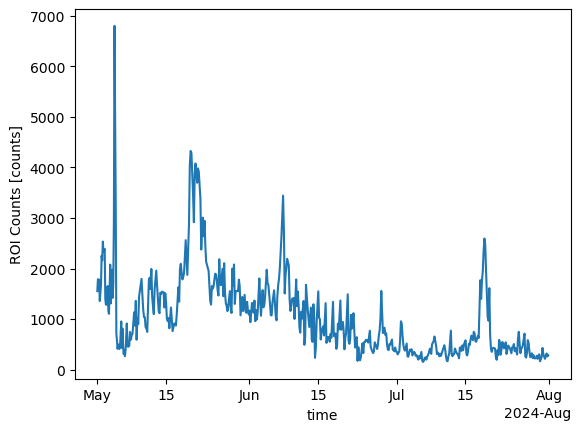

In [32]:
data_hdrsci.roi_count.plot(x="time")

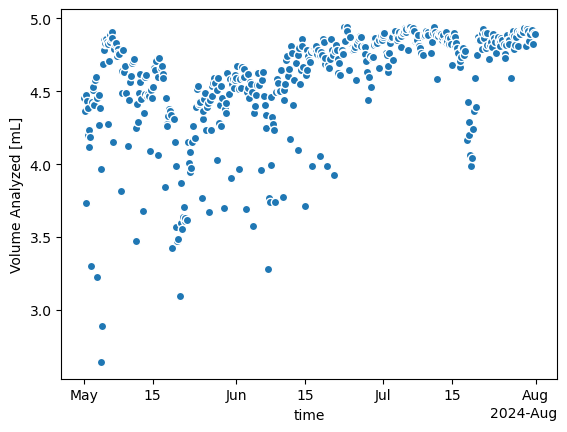

In [ ]:
data_hdrsci.volume_analyzed.plot.scatter(x="time", edgecolors="none", s=16)

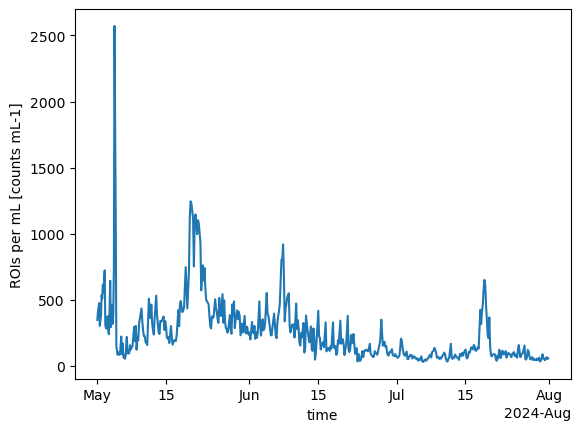

In [34]:
data_hdrsci.rois_per_ml.plot(x="time")

In [35]:
t_inhibit = data_hdrsci.inhibit_time.compute()
t_run = data_hdrsci.run_time.compute()
print(t_inhibit.head())
print(t_run.head())

<xarray.DataArray 'inhibit_time' (time: 5)> Size: 40B
array([131.93138021, 153.61402778, 304.78836806, 126.96220486,
       136.37450521])
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
Attributes:
    comment:      Accumulated time for which sample has not been analyzed
    units:        s
    long_name:    Total Inhibit Time
    _ChunkSizes:  483
<xarray.DataArray 'run_time' (time: 5)> Size: 40B
array([1201.30555556, 1200.92875   , 1201.01736111, 1200.99527778,
       1200.96333333])
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
Attributes:
    comment:      Accumulated time for which sample has been analyzed
    units:        s
    long_name:    Total Run Time
    _ChunkSizes:  483


In [36]:
calculated_look_time = t_run - t_inhibit
calculated_look_time.values == data_hdrsci.look_time.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Text(0, 0.5, 'Computed Look Time [s]')

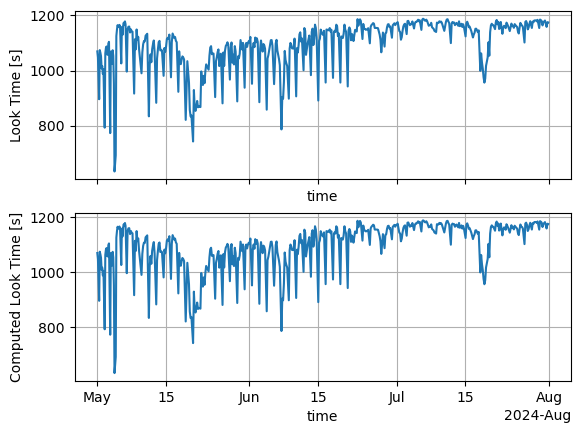

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True, layout="compact")
data_hdrsci.look_time.plot(ax=ax[0])
ax[0].grid()
calculated_look_time.plot(ax=ax[1])
ax[1].grid()
ax[1].set_ylabel("Computed Look Time [s]")

In [38]:
calculated_volume_analyzed = (t_run - t_inhibit)/(data_hdrsci.sample_volume - data_hdrsci.sample_speed)

In [39]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_telemetered_hdr_sci_{datetime.now()}.nc")

#### Telemetered ADC science data stream

In [40]:
# Setup parameters needed to request data
refdes = datastreams.refdes[3]
method = datastreams.method[3]
stream = datastreams.stream[3]

In [41]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [42]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-08T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [43]:
# Load the data
with ProgressBar():
    data_adcsci = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)

[########################################] | 100% Completed | 2.24 ss


In [44]:
# Check dataset content
data_adcsci

<xarray.Dataset> Size: 10MB
Dimensions:             (time: 79452)
Coordinates:
  * time                (time) datetime64[ns] 636kB 2024-05-01T00:25:18.17876...
Data variables: (12/19)
    inhibit_time_tr     (time) float32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
    peak_b              (time) float32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
    peak_a              (time) float32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
    grab_time_start     (time) float32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
    roi_status          (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    roi_width           (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    ...                  ...
    roi_x               (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    roi_y               (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    start_byte          (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    run_time_tr         (time) float32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
    roi_height          (time) float64 636kB dask.array<chunksize=(79452,), meta=np.ndarray>
    deployment          (time) int32 318kB dask.array<chunksize=(79452,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             plims_a_adc_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [45]:
# Check size of the dataset
data_adcsci.nbytes

9534240

In [47]:
# Check preferred timestamp
# Preferred timestamp not found in variables
# if the preprocess routine is applied
# data_adcsci.preferred_timestamp[0].values

In [48]:
# Check time values for triggers compared to sample time
print(data_adcsci.sample_timestamp[0].values) # Sample start time
print(data_adcsci.grab_time_start[0].values) # Time elapsed in seconds since the sample start time
print(data_adcsci.time[0].values) # Time of the first trigger of the sample

2024-05-01T00:25:09.000000000
9.178767
2024-05-01T00:25:18.178766848


In [49]:
# Calculate trigger times with grab_time_start + sample_timestamp 
grab_time_s =  data_adcsci["grab_time_start"].to_numpy()*1000000000
grab_time_s = grab_time_s.astype("timedelta64[ns]")
t_trigger_computed = grab_time_s+data_adcsci["sample_timestamp"]

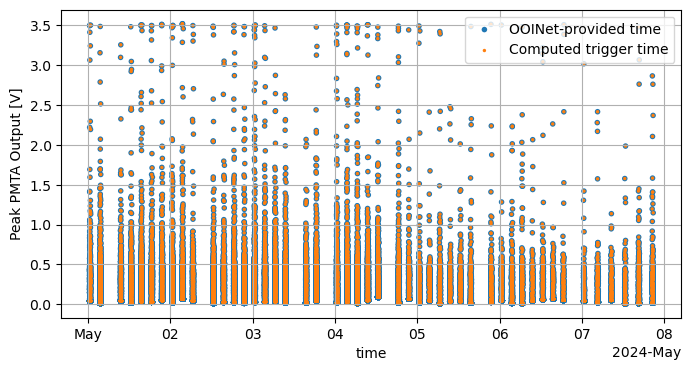

In [50]:
# Plot peak PMT A with OOINet-provided time 
# and our computed trigger time paramters
peak_a = data_adcsci.peak_a
fig = plt.figure(figsize=(8,4))
peak_a.plot.scatter(x="time", s=16, edgecolors="none", label="OOINet-provided time")
plt.scatter(t_trigger_computed, peak_a.values, s=6, edgecolors="none", label="Computed trigger time")
plt.grid()
plt.legend()

In [51]:
# Check for parameters removed from an earlier version of the ADC data stream code
parameters = ["inhibit_time", "run_time", "look_time"]
for p in parameters:
    try:
        p_is_here = data_adcsci.p
    except:
        print(f"{p} is not found in ADC science dataset")
    else:
        print(f"{p} is still in ADC science dataset")

inhibit_time is not found in ADC science dataset
run_time is not found in ADC science dataset
look_time is not found in ADC science dataset


In [52]:
# Check for standard names left in the dataset
names = list(())
for var in data_adcsci.variables:
    try:
        names.append(data_adcsci[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


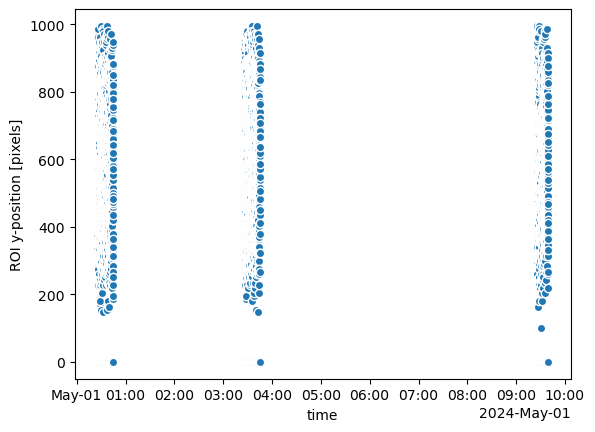

In [ ]:
data_adcsci.roi_y[0:5000].plot.scatter(x="time", edgecolors="none", s=16)

In [54]:
# data_adcsci.to_netcdf(f"./plims_data/dev0_telemetered_adc_sci_{datetime.now()}.nc")

#### Recovered host HDR engineering data stream

In [55]:
# Setup parameters needed to request data
refdes = datastreams.refdes[1]
method = datastreams.method[1]
stream = datastreams.stream[1]

In [56]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [57]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-08-01T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]



Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [58]:
# Load the data
with ProgressBar():
    data_hdreng2 = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)

[########################################] | 100% Completed | 1.02 ss


In [59]:
# Check dataset content
data_hdreng2

<xarray.Dataset> Size: 124kB
Dimensions:               (time: 483)
Coordinates:
  * time                  (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 2...
Data variables: (12/45)
    pump1_state           (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    refill_debubble       (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    prime_sample          (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    deployment            (time) int32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    alt_interval          (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    internal_temperature  (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    ...                    ...
    alt_pmta_threshold    (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    focus_motor_step_lg   (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    syringes_autorun      (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    auto_start            (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    detergent_rinse_vol   (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_volume_skip    (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_hdr_engineering
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [60]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdreng2.variables:
    try:
        names.append(data_hdreng2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


In [61]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdreng2.pump1_state.mean().values

array(1., dtype=float32)

In [62]:
# Check dtype for internal temperature
# This requires precision of float64 to match raw data.
print(f"Internal temperature dtype: {data_hdreng2.internal_temperature.dtype}")

Internal temperature dtype: float64


In [64]:
# Check that the time variable is coming from
# internal timestamp and the raw data filename.
# Preferred timestamp not found in variables if
# the preprocess routine is applied.
# data_hdreng2["preferred_timestamp"][0].values

In [65]:
data_hdreng2.alt_sample_counter

<xarray.DataArray 'alt_sample_counter' (time: 483)> Size: 4kB
dask.array<getitem, shape=(483,), dtype=float64, chunksize=(483,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 2024-07-31T20:...
Attributes:
    long_name:                 Alternate Settings Sample Counter
    alternate_parameter_name:  counter_alt
    comment:                   Seawater samples run since the last sample run...
    units:                     samples
    _ChunkSizes:               483

In [66]:
# data_hdreng2.to_netcdf("./plims_data/dev0_recoveredhost_hdr_eng.nc")

#### Recovered host HDR science data stream

In [67]:
# Setup parameters needed to request data
refdes = datastreams.refdes[2]
method = datastreams.method[2]
stream = datastreams.stream[2]

In [68]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [69]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-08-01T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [70]:
# Load the data
with ProgressBar():
    data_hdrsci2 = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)

[########################################] | 100% Completed | 917.40 ms


In [71]:
# Check dataset content
data_hdrsci2

<xarray.Dataset> Size: 100kB
Dimensions:             (time: 483)
Coordinates:
  * time                (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 202...
Data variables: (12/29)
    pmta_threshold      (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    rois_per_ml         (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    pmtb_threshold      (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_speed        (time) float32 2kB dask.array<chunksize=(483,), meta=np.ndarray>
    beads_counter       (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    run_fast_factor     (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    ...                  ...
    volume_analyzed     (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_gap_min        (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_area_min       (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    blob_x_grow         (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    look_time           (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
    sample_num          (time) float64 4kB dask.array<chunksize=(483,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_hdr_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [72]:
# Check for standard names left in the dataset
names = list(())
for var in data_hdrsci2.variables:
    try:
        names.append(data_hdrsci2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


In [73]:
# Check updated parameter attributes
data_hdrsci2.blob_gap_min.comment

'Minimum distance between blobs required to be separate ROIs'

In [74]:
# Check dtype for the following parameters
# These require precision of float64 to match raw data.
print(f"Internal humidity dtype: {data_hdrsci2.internal_humidity.dtype}")
print(f"Run time dtype: {data_hdrsci2.run_time.dtype}")
print(f"Inhibit time dtype: {data_hdrsci2.inhibit_time.dtype}")

Internal humidity dtype: float64
Run time dtype: float64
Inhibit time dtype: float64


In [75]:
# For logical values, check that the mean
# of values matches the expected result
# - 1 for True
# - 0 for False
data_hdrsci2.run_fast.mean().values

array(0., dtype=float32)

In [76]:
# Check attributes of parameters updated since 21 Mar
data_hdrsci2.pmta_threshold

<xarray.DataArray 'pmta_threshold' (time: 483)> Size: 2kB
dask.array<getitem, shape=(483,), dtype=float32, chunksize=(483,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 4kB 2024-05-01T00:25:09 ... 2024-07-31T20:...
Attributes:
    comment:                   Value that PMTA must exceed to trigger on PMTA
    precision:                 5
    long_name:                 PMTA Trigger Threshold
    units:                     V
    alternate_parameter_name:  pmta_trigger_threshold_daq_mcconly
    _ChunkSizes:               483

In [77]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

In [78]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

In [79]:
# data_hdrsci.to_netcdf(f"./plims_data/dev0_recoveredhost_hdr_sci_{datetime.now()}.nc")

#### Recovered host ADC science data stream

In [80]:
# Setup parameters needed to request data
refdes = datastreams.refdes[0]
method = datastreams.method[0]
stream = datastreams.stream[0]

In [81]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [82]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]

Waiting for request to process
Waiting for request to process
Waiting for request to process
Waiting for request to process


In [83]:
# Load the data
with ProgressBar():
    data_adcsci2 = xr.open_mfdataset(sensor_files, parallel=True, preprocess=preprocess)

[########################################] | 100% Completed | 2.45 ss


In [84]:
# Check dataset content
data_adcsci2

<xarray.Dataset> Size: 16MB
Dimensions:             (time: 136737)
Coordinates:
  * time                (time) datetime64[ns] 1MB 2024-05-01T00:25:18.1787668...
Data variables: (12/19)
    inhibit_time_tr     (time) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    peak_b              (time) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    peak_a              (time) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    grab_time_start     (time) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    roi_status          (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    roi_width           (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    ...                  ...
    roi_x               (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    roi_y               (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    start_byte          (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    run_time_tr         (time) float32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
    roi_height          (time) float64 1MB dask.array<chunksize=(136737,), meta=np.ndarray>
    deployment          (time) int32 547kB dask.array<chunksize=(136737,), meta=np.ndarray>
Attributes: (12/69)
    node:                               RID27
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             plims_a_adc_instrument
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                35.94988
    lon:                                -75.11943

In [85]:
# Check attributes of paramaters updated since 21 Mar
data_adcsci2.roi_y

<xarray.DataArray 'roi_y' (time: 136737)> Size: 1MB
dask.array<getitem, shape=(136737,), dtype=float64, chunksize=(136737,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1MB 2024-05-01T00:25:18.178766848 ... 2024...
Attributes:
    long_name:    ROI y-position
    comment:      Y-position of the upper left corner of the bounding box for...
    units:        pixels
    _ChunkSizes:  10000

In [86]:
# Check for parameters removed from an earlier version of the ADC data stream code
parameters = ["inhibit_time", "run_time", "look_time"]
for p in parameters:
    try:
        p_is_here = data_adcsci2.p
    except:
        print(f"{p} is not found in ADC science dataset")
    else:
        print(f"{p} is still in ADC science dataset")

inhibit_time is not found in ADC science dataset
run_time is not found in ADC science dataset
look_time is not found in ADC science dataset


In [87]:
# Check for standard names left in the dataset
names = list(())
for var in data_adcsci2.variables:
    try:
        names.append(data_adcsci2[var].standard_name)
    except:
        continue
print(f"Remaining standard names: {names}")

Remaining standard names: ['time']


In [88]:
# data_adcsci.to_netcdf(f"./plims_data/dev0_recoveredhost_adc_sci_{datetime.now()}.nc")

## Check data accuracy

Early versions of the PLIMS NetCDFs showed inaccuracies due to a loss of precision in the float data type (32-bit) for multiple parameters. These were changed to the double data type (64-bit), but the efficacy of the updates need to be confirmed.

In [89]:
# Define routine to return any offset between the timestamp of record and sample start time
def test_time_delta(data):
    t_delta = data["internal_timestamp"] - data["sample_timestamp"]
    print(t_delta.head())
    check = (t_delta == 0)
    if check.all() == True:
        t_delta = "No offset."
    return t_delta

In [90]:
# Test for a time delta in both HDR data streams
# Telemetered
tdel_hdrsci = test_time_delta(data_hdrsci)
print(tdel_hdrsci)
tdel_hdreng = test_time_delta(data_hdreng)
print(tdel_hdreng)
# Recovered Host
tdel_hdrsci2 = test_time_delta(data_hdrsci2)
print(tdel_hdrsci2)
tdel_hdreng2 = test_time_delta(data_hdreng2)
print(tdel_hdreng2)

<xarray.DataArray (time: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
No offset.
<xarray.DataArray (time: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
No offset.
<xarray.DataArray (time: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
No offset.
<xarray.DataArray (time: 5)> Size: 40B
dask.array<getitem, shape=(5,), dtype=timedelta64[ns], chunksize=(5,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-05-01T00:25:09 ... 2024-05-01T15:...
No offset.


## HDR Science data visualizations

## ADC Science data visualizations

Text(0.5, 0.98, 'Pioneer MAB Central Surface Mooring \nPlankton Imaging Sensor Peak PMT in May 2024')

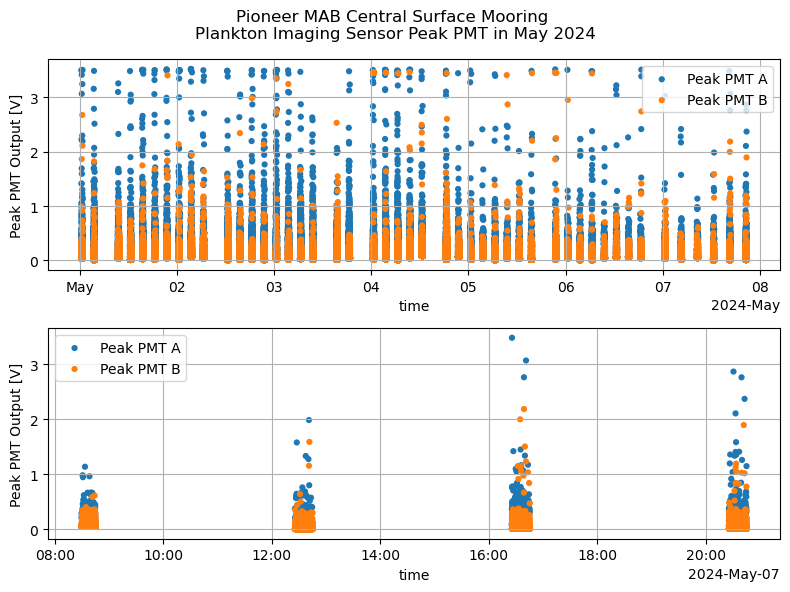

In [95]:
# Peak PMT A/B sample plot
fig, axs = plt.subplots(2, 1, figsize=(8,6), layout="tight")
# Peak PMTs during sampling on 1 May 2025
data_adcsci.peak_a.plot.scatter(x="time", s=20, edgecolors="none", ax=axs[0], label="Peak PMT A")
data_adcsci.peak_b.plot.scatter(x="time", s=20, edgecolors="none", ax=axs[0], label="Peak PMT B")
axs[0].set_ylabel("Peak PMT Output [V]")
axs[0].legend()
axs[0].grid()
# Peak PMTs during last sample on 1 May 2025
data_adcsci.peak_a[-2300:].plot.scatter(x="time", s=20, edgecolors="none", ax=axs[1], label="Peak PMT A")
data_adcsci.peak_b[-2300:].plot.scatter(x="time", s=20, edgecolors="none", ax=axs[1], label="Peak PMT B")
axs[1].set_ylabel("Peak PMT Output [V]")
axs[1].legend()
axs[1].grid()
fig.suptitle("Pioneer MAB Central Surface Mooring \nPlankton Imaging Sensor Peak PMT in May 2024")

Text(0.5, 0, 'Time of Flight [s]')

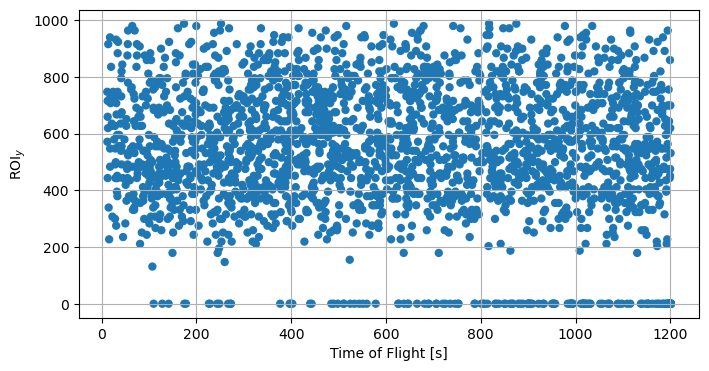

In [92]:
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["grab_time_start"][-2300:], data_adcsci["roi_y"][-2300:], edgecolors="none")
plt.grid()
plt.ylabel("ROI$_y$")
plt.xlabel("Time of Flight [s]")

Text(0.5, 0, 'Time')

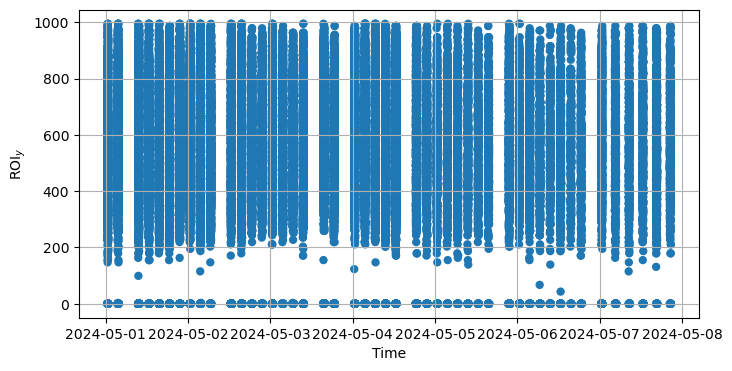

In [93]:
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["time"], data_adcsci["roi_y"], edgecolors="none")
plt.grid()
plt.ylabel("ROI$_y$")
plt.xlabel("Time")

Text(0.5, 1.0, 'ROI sizes from 2024-05-01 to 2024-05-07')

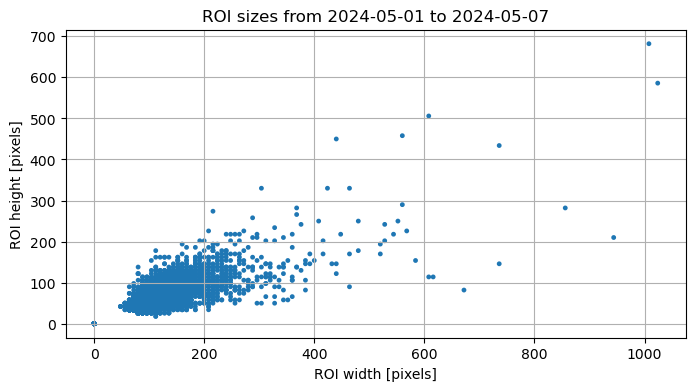

In [103]:
# Plot ROI width v. ROI height for 1 week of data in May 2024
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci["roi_width"], data_adcsci["roi_height"], edgecolors="none", s=12)
plt.grid()
plt.ylabel("ROI height [pixels]")
plt.xlabel("ROI width [pixels]")
plt.title(f"ROI sizes from {np.datetime_as_string(
    data_adcsci.time[0].values, unit='D')} to {np.datetime_as_string(
    data_adcsci.time[-1].values, unit='D')}")

Text(0.5, 1.0, 'ROI sizes from 2024-05-01 to 2024-05-14')

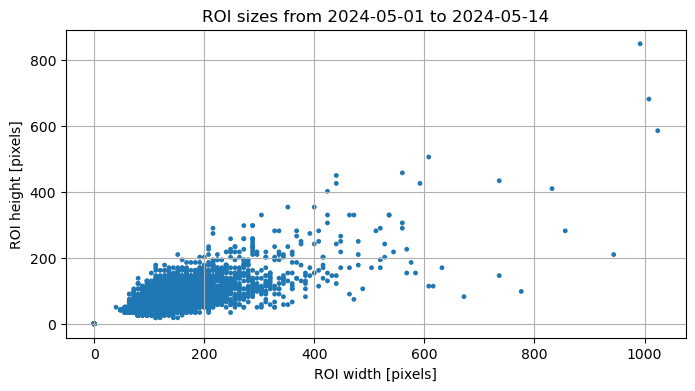

In [104]:
# ROI width v. ROI height for 2 weeks of data in May 2024
plt.figure(figsize=(8,4))
plt.scatter(data_adcsci2["roi_width"], data_adcsci2["roi_height"], edgecolors="none", s=12)
plt.grid()
plt.ylabel("ROI height [pixels]")
plt.xlabel("ROI width [pixels]")
plt.title(f"ROI sizes from {np.datetime_as_string(
    data_adcsci2.time[0].values, unit='D')} to {np.datetime_as_string(
    data_adcsci2.time[-1].values, unit='D')}")

## Plots that combine HDR and ADC science data